In [ ]:
pip install tensorflow

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("pacificrm/skindiseasedataset")

print("Path to dataset files:", path)

100%|██████████| 1.36G/1.36G [00:11<00:00, 123MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/pacificrm/skindiseasedataset/versions/6


In [3]:
!cp -r "$path" /content/skindiseasedataset


In [4]:
import tensorflow as tf

In [5]:
# Set random seed for reproducibility
tf.random.set_seed(42)

In [6]:
# Define paths for train and test sets, assuming they are directly in the Colab environment
train_dir = '/content/skindiseasedataset/SkinDisease/SkinDisease/train'
test_dir = '/content/skindiseasedataset/SkinDisease/SkinDisease/test'

In [7]:
!pip install -q tqdm

In [ ]:
# ===================== SINGLE-CELL FULL PIPELINE =====================

# Install tqdm (safe to re-run)
!pip install -q tqdm

# --------------------- IMPORTS ---------------------

from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tqdm.keras import TqdmCallback

import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# --------------------- CONFIG ---------------------
IMG_SIZE = (224, 224)
BATCH_SIZE = 16          # Colab-stable
NUM_CLASSES = 22

EPOCHS_BASELINE = 12
EPOCHS_TL = 8
EPOCHS_FINE = 4

# --------------------- DATA GENERATORS ---------------------
train_val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

train_gen = train_val_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training"
)

val_gen = train_val_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

# --------------------- CALLBACKS ---------------------
callbacks = [
    TqdmCallback(verbose=1),
    ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_accuracy"),
    EarlyStopping(patience=3, restore_best_weights=True)
]

# ===================== STEP 1: BASELINE CNN =====================
baseline_model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

baseline_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

print("\n===== Training Baseline CNN =====")
start = time.time()
baseline_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS_BASELINE,
    callbacks=callbacks
)
baseline_time = time.time() - start

# ===================== STEP 2: EFFICIENTNET-B0 =====================
base_model = tf.keras.applications.EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)
base_model.trainable = False

eff_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation="softmax")
])

eff_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

print("\n===== Training EfficientNet (Frozen) =====")
start = time.time()
eff_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS_TL,
    callbacks=callbacks
)
eff_time = time.time() - start

# --------------------- FINE-TUNING ---------------------
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

eff_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

print("\n===== Fine-tuning EfficientNet =====")
eff_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS_FINE,
    callbacks=callbacks
)

# ===================== STEP 3: EVALUATION =====================
print("\n===== Evaluation on Test Set =====")
baseline_acc = baseline_model.evaluate(test_gen)[1]
eff_acc = eff_model.evaluate(test_gen)[1]

print(f"Baseline Accuracy      : {baseline_acc:.4f}")
print(f"EfficientNet Accuracy  : {eff_acc:.4f}")

# --------------------- CONFUSION MATRIX ---------------------
y_true = test_gen.classes
y_pred = np.argmax(eff_model.predict(test_gen), axis=1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=test_gen.class_indices.keys())

plt.figure(figsize=(10,10))
disp.plot(xticks_rotation=90)
plt.title("EfficientNet-B0 Confusion Matrix")
plt.show()

# --------------------- TRAINING TIME ---------------------
print(f"Baseline Training Time    : {baseline_time:.2f} seconds")
print(f"EfficientNet Training Time: {eff_time:.2f} seconds")

# ===================== END =====================


In [ ]:
# ===================== CORRECTED EFFICIENTNET (COMPARISON RUN) =====================

from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tqdm.keras import TqdmCallback
import tensorflow as tf

# ---------------- CONFIG ----------------
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
NUM_CLASSES = 22
EPOCHS_FROZEN = 10
EPOCHS_FINE = 5

# ---------------- DATA (CORRECT PREPROCESSING) ----------------
eff_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

eff_train_gen = eff_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training"
)

eff_val_gen = eff_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

eff_test_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
).flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

# ---------------- MODEL ----------------
base_model = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)
base_model.trainable = False

eff_corrected = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation="softmax")
])

eff_corrected.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# ---------------- CALLBACKS ----------------
callbacks = [
    TqdmCallback(verbose=1),
    ModelCheckpoint(
        "/content/drive/MyDrive/models/efficientnet_corrected_best.h5",
        save_best_only=True,
        monitor="val_accuracy"
    ),
    EarlyStopping(patience=3, restore_best_weights=True)
]

# ---------------- TRAIN (FROZEN) ----------------
print("\n===== Corrected EfficientNet (Frozen) =====")
eff_corrected.fit(
    eff_train_gen,
    validation_data=eff_val_gen,
    epochs=EPOCHS_FROZEN,
    callbacks=callbacks
)

# ---------------- FINE-TUNING ----------------
base_model.trainable = True
for layer in base_model.layers[:-40]:
    layer.trainable = False

eff_corrected.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

print("\n===== Corrected EfficientNet (Fine-tuning) =====")
eff_corrected.fit(
    eff_train_gen,
    validation_data=eff_val_gen,
    epochs=EPOCHS_FINE,
    callbacks=callbacks
)

# ---------------- EVALUATION ----------------
test_acc = eff_corrected.evaluate(eff_test_gen)[1]
print(f"\n✅ Corrected EfficientNet Test Accuracy: {test_acc:.4f}")


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

97/97 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step


<Figure size 1000x1000 with 0 Axes>

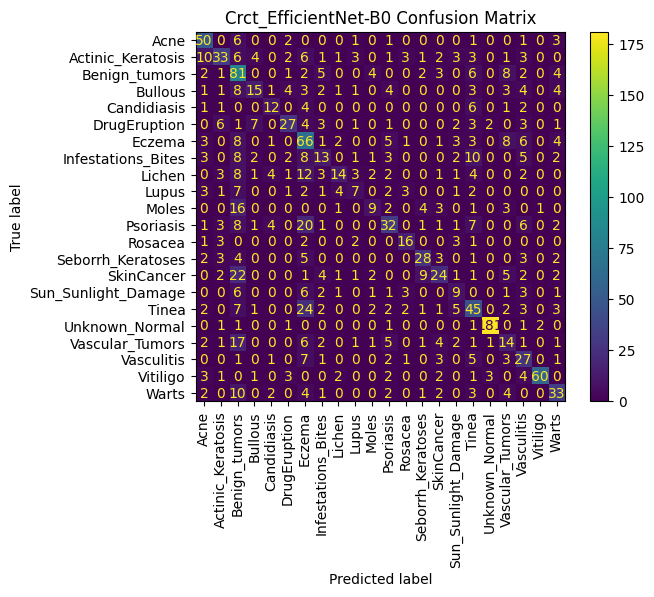

In [15]:
y_true = eff_test_gen.classes
y_pred = np.argmax(eff_corrected.predict(eff_test_gen), axis=1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=eff_test_gen.class_indices.keys())

plt.figure(figsize=(10,10))
disp.plot(xticks_rotation=90)
plt.title("Crct_EfficientNet-B0 Confusion Matrix")
plt.show()

In [ ]:
# ===================== SAVE MODEL (.keras + .h5) =====================

import os

save_dir = "/content/saved_models"
os.makedirs(save_dir, exist_ok=True)

# Save 
keras_path = f"{save_dir}/efficientnet_dermatology_final.keras"
eff_corrected.save(keras_path)
h5_path = f"{save_dir}/efficientnet_dermatology_final.h5"
eff_corrected.save(h5_path)

print("Model saved in both formats:")
print(keras_path)
print(h5_path)
